### Overview
The goal of this competition is classification of mixed protein patterns. However, unlike most image labeling tasks, where binary or multiclass labeling is considered, in this competition each image can have multiple labels. Multiclass multilabel task has its own specific affecting the design of the model and the loss function. Moreover, the classified images are quite different from ImageNet; therefore, despite usage of a pretrained model is quite helpful, a substantial retraining of entire model is needed. An additional challenge is 4-chanel input to the model (RGBY), which is different from ones used in most of pretrained models (RGB input).

In this kernel I will show how to handle the above challenges and get started with this competition. I will begin with using a light ResNet34 model and low-resolution images to have a baseline that can be used later to select higher end models and explore the effect of image resolution on the prediction accuracy. **The validation F1 score of the model is ~0.65-0.7**, and I was able to get 0.460 public LB score in V11 of the kernel. Though reuslts are slightly different from one run to another because F1 macro metric is unstable, and sevral items of rear classes contribute in the same way as as thousands items of common classes, 1/28.

The problem of low public LB score of the model, which mentioned in the first versions of the kernel, is resulted by a bug in the evaluation metric (https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/69366#409041) that relies on the order of records in the submission file rather than IDs.

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt

import warnings
warnings.filterwarnings("ignore")

In [4]:
PATH = './'
TRAIN = '/kaggle_data/human_protein/train_all_png4_scale/'
TEST = '/kaggle_data/human_protein/test_png4/'
LABELS = '../input/train.csv'
LABELS_EXT = '../input/train_ext.csv'
#LABELS_AUG = '../input/train_aug01.csv'
SAMPLE = '../input/sample_submission.csv'
CLASS_WEIGHTS = '../input/class_weight_005.csv'

RUN_ALL_TRAIN = True

In [5]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [244]:
nw = 2   #number of workers for data loader
arch = resnext50 # wrn
seed = 42

In [5]:
# model_meta = {
#     resnet18:[8,6], resnet34:[8,6], resnet50:[8,6], resnet101:[8,6], resnet152:[8,6],
#     vgg16:[0,22], vgg19:[0,22],
#     resnext50:[8,6], resnext101:[8,6], resnext101_64:[8,6],
#     wrn:[8,6], inceptionresnet_2:[-2,9], inception_4:[-1,9],
#     dn121:[0,7], dn161:[0,7], dn169:[0,7], dn201:[0,7],
# }

### Data

In [245]:
labels = pd.read_csv(LABELS)
labels_ext = pd.read_csv(LABELS_EXT)
#labels_aug = pd.read_csv(LABELS_AUG)
labels = pd.concat([labels, labels_ext])
train_names = list(labels['Id'])
test_names = list({f[:f.rfind('.')] for f in os.listdir(TEST)})
tr_n_init, val_n = train_test_split(train_names, test_size=0.1, random_state=seed)

In [247]:
#creating duplicates for rare classes in train set
class Oversampling:
    def __init__(self, labels):
        self.train_labels = labels.set_index('Id')
        self.train_labels['Target'] = [[int(i) for i in s.split()] for s in self.train_labels['Target']]
        #set the minimum number of duplicates for each class
        self.class_weight = pd.read_csv(CLASS_WEIGHTS, header=None)
        self.multi = list(self.class_weight.values[:,-1])      
        print(self.multi)
#         self.multi = [1,1,1,1,1,1,1,1,
#                       8,8,8,1,1,1,1,8,
#                       1,2,1,1,4,1,1,1,
#                       2,1,2,8]

    def get(self,image_id):
        labels = self.train_labels.loc[image_id,'Target'] if image_id \
          in self.train_labels.index else []
        m = 1
        for l in labels:
            if m < self.multi[l]: m = self.multi[l]
        return m
    
s = Oversampling(labels)

if RUN_ALL_TRAIN:
    tr_n_os = [idx for idx in train_names for _ in range(s.get(idx))]
else:
    tr_n_os = [idx for idx in tr_n_init for _ in range(s.get(idx))]

tr_n = random.sample(tr_n_os, len(tr_n_os))
print(len(tr_n),flush=True)

[1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 1, 2, 1, 5, 2, 3, 1, 1, 3, 1, 1, 1, 3, 1, 2, 4]
113553


In [248]:
train_names[0:6]

['00070df0-bbc3-11e8-b2bc-ac1f6b6435d0',
 '000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0',
 '000a9596-bbc4-11e8-b2bc-ac1f6b6435d0',
 '000c99ba-bba4-11e8-b2b9-ac1f6b6435d0',
 '001838f8-bbca-11e8-b2bc-ac1f6b6435d0',
 '001bcdd2-bbb2-11e8-b2ba-ac1f6b6435d0']

In [249]:
test_names[0:6]

['2f565d76-bad9-11e8-b2b9-ac1f6b6435d0',
 'f0a6d40a-bacb-11e8-b2b8-ac1f6b6435d0',
 '63e2c020-baca-11e8-b2b8-ac1f6b6435d0',
 'c3a1ddce-bada-11e8-b2b9-ac1f6b6435d0',
 'e3d73fd8-bad7-11e8-b2b9-ac1f6b6435d0',
 'ec0560d0-bad3-11e8-b2b8-ac1f6b6435d0']

In [250]:
tr_n[0:6]

['5d230476-bba5-11e8-b2ba-ac1f6b6435d0',
 '34664_686_B10_1',
 '43836_496_E7_3',
 '2bbfc332-bb9c-11e8-b2b9-ac1f6b6435d0',
 '35162_1558_G7_3',
 '8e9797e2-bbc3-11e8-b2bc-ac1f6b6435d0']

In [251]:
print(len(train_names), len(tr_n), len(val_n),len(test_names))

105678 113553 10568 11702


Since a multiclass multilabel task is considered, there are several things about the model that should be pointed out. First, the SOFTMAX MUST NOT BE USED as an output layer because it encourages a single label prediction. The common output function for multilabel tasks is sigmoid. However, combining the sigmoid with the loss function (like in BCE with logits loss or in Focal loss used in this kernel) allows log(sigmoid) optimization of the numerical stability of the loss function. Therefore, sigmoid is also removed.

In [252]:
from IPython.core.debugger import set_trace
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels_ext = pd.read_csv(LABELS_EXT).set_index('Id')
#         self.labels_aug = pd.read_csv(LABELS_AUG).set_index('Id')
#         self.labels = pd.concat([self.labels, self.labels_ext, self.labels_aug])
        self.labels = pd.concat([self.labels, self.labels_ext])
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        try:
#             img = cv2.imread(os.path.join(self.path, self.fnames[i] + '.png'), \
#                          cv2.IMREAD_UNCHANGED).astype(np.float32)/255
            img = cv2.imread(os.path.join(self.path, self.fnames[i] + '.png')).astype(np.float32)/255            
        except:
            set_trace()
            print(path,Id)
        
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes

In [253]:
def get_data(sz,bs,nsamp=96000):
    #data augmentation
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    #mean and std in of each channel in the train set
    stats = A([0.08069, 0.05258, 0.05487], [0.13704, 0.10145, 0.15313]) # official data
#    stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814]) # official data
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    
    if RUN_ALL_TRAIN:
        ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    else:
        ds = ImageData.get_ds(pdFilesDataset, (tr_n[:nsamp],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
        
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [254]:
bs = 16 
sz = 512 # 256
md = get_data(sz,bs)
x,y = next(iter(md.trn_dl))
x.shape, y.shape

(torch.Size([16, 3, 512, 512]), torch.Size([16, 28]))

Plot several examples of input images.

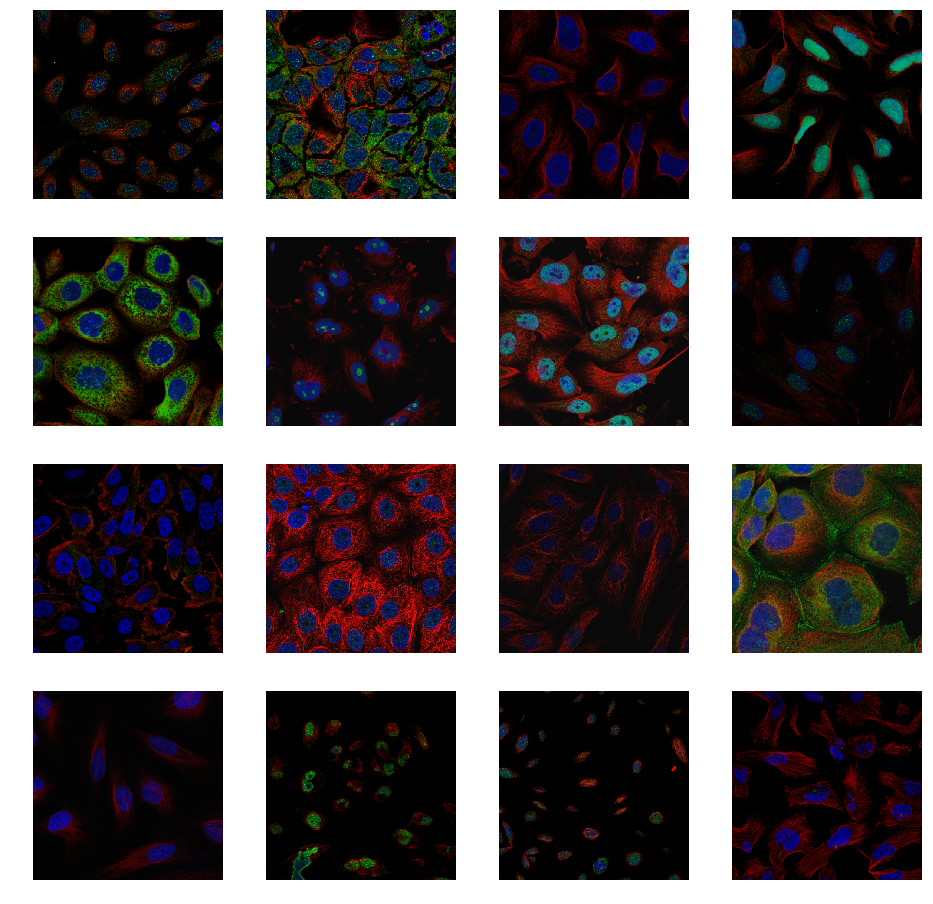

In [15]:
def display_imgs(x):
    columns = 4
    bs = x.shape[0]
    rows = min((bs+3)//4,4)
    fig=plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow((x[idx,:,:,:3]*255).astype(np.int))
    plt.show()
    
display_imgs(np.asarray(md.trn_ds.denorm(x)))

Computing image statistics in the train set. The values listed below are computed without augmentation, therefore the result of the next cell may be a little bit different.
1. train: (array([0.08069, 0.05258, 0.05487, 0.08282]), array([0.13704, 0.10145, 0.15313, 0.13814]))
1. test: (array([0.05913, 0.0454 , 0.04066, 0.05928]),  array([0.11734, 0.09503, 0.129  , 0.11528]))
1. all data including scaled HPAv18 data  
(array([0.08346, 0.05585, 0.05985, 0.08515]), array([0.12101, 0.09127, 0.13204, 0.12586]))

In [16]:
# %%time
# x_tot = np.zeros(4)
# x2_tot = np.zeros(4)
# for x,y in iter(md.trn_dl):
#     tmp =  md.trn_ds.denorm(x).reshape(16,-1)
#     x = md.trn_ds.denorm(x).reshape(-1,4)
#     x_tot += x.mean(axis=0)
#     x2_tot += (x**2).mean(axis=0)

# channel_avr = x_tot/len(md.trn_dl)
# channel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)
# channel_avr,channel_std
# # to be put into stats in get_data()

CPU times: user 1h 39min 11s, sys: 35min 12s, total: 2h 14min 24s
Wall time: 59min 25s

In [17]:
# channel_avr,cha

(array([0.08346, 0.05585, 0.05985, 0.08515]),
 array([0.12101, 0.09127, 0.13204, 0.12586]))

In [18]:
# channel_avr,channel_std - scaled version
# (array([0.08346, 0.05585, 0.05985, 0.08515]),
#  array([0.12101, 0.09127, 0.13204, 0.12586]))

### Loss function and metrics

One of the challenges of this competition is strong data imbalance. Some classes, like "Nucleoplasm", are very common, while there is a number of rare classes, like "Endosomes", "Lysosomes", and "Rods & rings". In addition, in tasks of multiclass, and especially in multilabel, classification there is always an issue with data imbalance: if you predict 1 class out of 10, given the same number of examples per each class, you have 1 positive vs. 9 negative examples. So, it is crucial to use a loss function that accounts for it. Recently proposed focal loss (https://arxiv.org/pdf/1708.02002.pdf) has revolutionized one stage object localization method in 2017. It is design to address the issue of strong data imbalance, demonstrating amazing results on datasets with imbalance level 1:10-1000. In particular, it works quite well for image segmentation task in "Airbus Ship Detection Challenge": https://www.kaggle.com/iafoss/unet34-dice-0-87 .  The implementation of focal loss is borrowed from https://becominghuman.ai/investigating-focal-and-dice-loss-for-the-kaggle-2018-data-science-bowl-65fb9af4f36c .

In [255]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [256]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

### Training

One of the challenges in this competition is 4-chanel input (RGBY) that limits usage of ImageNet pretrained models taking RGB input. However, the input dataset is too tiny to train even a low capacity model like ResNet34 from scratch. I propose to use the following way to walk around this limitation. The most common way to convert RGBY to RGB is just dropping Y channel while keeping RGB without modification. Therefore, I replace the first convolution layer from 7x7 3->64 to 7x7 **4->64** while keeping weights from 3->64 and setting new initial weighs for Y channel to be zero. It allows using the original weights to initialize the network while giving the opportunity to the model to incorporate Y channel into prediction during the following training (when the first layers of the model are unfreezed). In the following hiden cell I put a code from fast.ai library with adding several lines for the replacment of the first convolutional layer.

In [21]:
# class ConvnetBuilder_custom():
#     def __init__(self, f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, 
#                  custom_head=None, pretrained=True):
#         self.f,self.c,self.is_multi,self.is_reg,self.xtra_cut = f,c,is_multi,is_reg,xtra_cut
#         if xtra_fc is None: xtra_fc = [512]
#         if ps is None: ps = [0.25]*len(xtra_fc) + [0.5]
#         self.ps,self.xtra_fc = ps,xtra_fc

#         if f in model_meta: cut,self.lr_cut = model_meta[f]
#         else: cut,self.lr_cut = 0,0
#         cut-=xtra_cut
#         layers = cut_model(f(pretrained), cut)
        
#         #replace first convolutional layer by 4->64 while keeping corresponding weights
#         #and initializing new weights with zeros
#         # set channel back to rgb (3->64)
#         layers[0] = nn.Conv2d(3,64,kernel_size=(7,7),stride=(2,2),padding=(3, 3), bias=False)

#         # 4-channel un-commented the following two lines of code
# #         w = layers[0].weight
# #         layers[0].weight = torch.nn.Parameter(torch.cat((w,w[:,:1,:,:]),dim=1))
#         self.nf = model_features[f] if f in model_features else (num_features(layers)*2)
#         if not custom_head: layers += [AdaptiveConcatPool2d(), Flatten()]
#         self.top_model = nn.Sequential(*layers)

#         n_fc = len(self.xtra_fc)+1
#         if not isinstance(self.ps, list): self.ps = [self.ps]*n_fc

#         if custom_head: fc_layers = [custom_head]
#         else: fc_layers = self.get_fc_layers()
#         self.n_fc = len(fc_layers)
#         self.fc_model = to_gpu(nn.Sequential(*fc_layers))
#         if not custom_head: apply_init(self.fc_model, kaiming_normal)
#         self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))

#     @property
#     def name(self): return f'{self.f.__name__}_{self.xtra_cut}'

#     def create_fc_layer(self, ni, nf, p, actn=None):
#         res=[nn.BatchNorm1d(num_features=ni)]
#         if p: res.append(nn.Dropout(p=p))
#         res.append(nn.Linear(in_features=ni, out_features=nf))
#         if actn: res.append(actn)
#         return res

#     def get_fc_layers(self):
#         res=[]
#         ni=self.nf
#         for i,nf in enumerate(self.xtra_fc):
#             res += self.create_fc_layer(ni, nf, p=self.ps[i], actn=nn.ReLU())
#             ni=nf
#         final_actn = nn.Sigmoid() if self.is_multi else nn.LogSoftmax()
#         if self.is_reg: final_actn = None
#         res += self.create_fc_layer(ni, self.c, p=self.ps[-1], actn=final_actn)
#         return res

#     def get_layer_groups(self, do_fc=False):
#         if do_fc:
#             return [self.fc_model]
#         idxs = [self.lr_cut]
#         c = children(self.top_model)
#         if len(c)==3: c = children(c[0])+c[1:]
#         lgs = list(split_by_idxs(c,idxs))
#         return lgs+[self.fc_model]
    
# class ConvLearner(Learner):
#     def __init__(self, data, models, precompute=False, **kwargs):
#         self.precompute = False
#         super().__init__(data, models, **kwargs)
#         if hasattr(data, 'is_multi') and not data.is_reg and self.metrics is None:
#             self.metrics = [accuracy_thresh(0.5)] if self.data.is_multi else [accuracy]
#         if precompute: self.save_fc1()
#         self.freeze()
#         self.precompute = precompute

#     def _get_crit(self, data):
#         if not hasattr(data, 'is_multi'): return super()._get_crit(data)

#         return F.l1_loss if data.is_reg else F.binary_cross_entropy if data.is_multi else F.nll_loss

#     @classmethod
#     def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
#                    pretrained=True, **kwargs):
#         models = ConvnetBuilder_custom(f, data.c, data.is_multi, data.is_reg,
#             ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=pretrained)
#         return cls(data, models, precompute, **kwargs)

#     @classmethod
#     def lsuv_learner(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
#                   needed_std=1.0, std_tol=0.1, max_attempts=10, do_orthonorm=False, **kwargs):
#         models = ConvnetBuilder(f, data.c, data.is_multi, data.is_reg,
#             ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=False)
#         convlearn=cls(data, models, precompute, **kwargs)
#         convlearn.lsuv_init()
#         return convlearn
    
#     @property
#     def model(self): return self.models.fc_model if self.precompute else self.models.model
    
#     def half(self):
#         if self.fp16: return
#         self.fp16 = True
#         if type(self.model) != FP16: self.models.model = FP16(self.model)
#         if not isinstance(self.models.fc_model, FP16): self.models.fc_model = FP16(self.models.fc_model)
#     def float(self):
#         if not self.fp16: return
#         self.fp16 = False
#         if type(self.models.model) == FP16: self.models.model = self.model.module.float()
#         if type(self.models.fc_model) == FP16: self.models.fc_model = self.models.fc_model.module.float()

#     @property
#     def data(self): return self.fc_data if self.precompute else self.data_

#     def create_empty_bcolz(self, n, name):
#         return bcolz.carray(np.zeros((0,n), np.float32), chunklen=1, mode='w', rootdir=name)

#     def set_data(self, data, precompute=False):
#         super().set_data(data)
#         if precompute:
#             self.unfreeze()
#             self.save_fc1()
#             self.freeze()
#             self.precompute = True
#         else:
#             self.freeze()

#     def get_layer_groups(self):
#         return self.models.get_layer_groups(self.precompute)

#     def summary(self):
#         precompute = self.precompute
#         self.precompute = False
#         res = super().summary()
#         self.precompute = precompute
#         return res

#     def get_activations(self, force=False):
#         tmpl = f'_{self.models.name}_{self.data.sz}.bc'
#         # TODO: Somehow check that directory names haven't changed (e.g. added test set)
#         names = [os.path.join(self.tmp_path, p+tmpl) for p in ('x_act', 'x_act_val', 'x_act_test')]
#         if os.path.exists(names[0]) and not force:
#             self.activations = [bcolz.open(p) for p in names]
#         else:
#             self.activations = [self.create_empty_bcolz(self.models.nf,n) for n in names]

#     def save_fc1(self):
#         self.get_activations()
#         act, val_act, test_act = self.activations
#         m=self.models.top_model
#         if len(self.activations[0])!=len(self.data.trn_ds):
#             predict_to_bcolz(m, self.data.fix_dl, act)
#         if len(self.activations[1])!=len(self.data.val_ds):
#             predict_to_bcolz(m, self.data.val_dl, val_act)
#         if self.data.test_dl and (len(self.activations[2])!=len(self.data.test_ds)):
#             if self.data.test_dl: predict_to_bcolz(m, self.data.test_dl, test_act)

#         self.fc_data = ImageClassifierData.from_arrays(self.data.path,
#                 (act, self.data.trn_y), (val_act, self.data.val_y), self.data.bs, classes=self.data.classes,
#                 test = test_act if self.data.test_dl else None, num_workers=8)

#     def freeze(self):
#         self.freeze_to(-1)

#     def unfreeze(self):
#         self.freeze_to(0)
#         self.precompute = False

#     def predict_array(self, arr):
#         precompute = self.precompute
#         self.precompute = False
#         pred = super().predict_array(arr)
#         self.precompute = precompute
#         return pred

In [22]:
# #True class weights:
# class_weight_lin = {0: 0.0012, 1: 0.0163, 2: 0.0046, 3: 0.015, 4: 0.0097, 5: 0.0084, 6: 0.0134, 7: 0.0053,\
#                     8: 0.2304, 9: 0.2538, 10: 0.2747, 11: 0.0228, 12: 0.0224, 13: 0.0343, 14: 0.0186, \
#                     15: 0.7937, 16: 0.0388, 17: 0.1121, 18: 0.0264, 19: 0.0136, 20: 0.1142, 21: 0.0036, \
#                     22: 0.0183, 23: 0.0048, 24: 0.1168, 25: 0.0013, 26: 0.0708, 27: 0.3937}

# #bce_criterion_class = nn.BCEWithLogitsLoss(weight=class_weight, reduce=False)
# #multi_criterion_class = nn.MultiLabelSoftMarginLoss(weight=class_weight, reduce=False)

In [257]:
sz = 512 #256 #image size
bs = 8  #batch size # 16 for resnet34  #12 for resnet50 #8 for resnext50 #6 for wrn, inceptionresnet_2
nsamp = 96000
md = get_data(sz,bs,nsamp)
learner = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
#learner = ConvLearner.pretrained(arch, md, precompute=True, ps=0.5) #dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss(gamma=2.0)
#learner.crit = nn.BCEWithLogitsLoss(weight=class_weight_lin, reduce=False)
learner.metrics = [acc]

In [24]:
# learner.summary

I begin with finding the optimal learning rate. The following function runs training with different lr and records the loss. Increase of the loss indicates onset of divergence of training. The optimal lr lies in the vicinity of the minimum of the curve but before the onset of divergence. Based on the following plot, for the current setup the divergence starts at ~0.1, and the recommended learning rate is ~0.02.

 65%|██████▌   | 5214/8000 [22:16<11:03,  4.20it/s, loss=5.57]

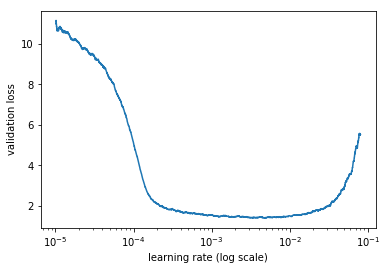

In [12]:
learner.lr_find()
learner.sched.plot()

In [258]:
lr = 2e-4

First, I train only the head of the model while keeping the rest frozen. It allows to avoid corruption of the pretrained weights at the initial stage of training due to random initialization of the head layers. So the power of transfer learning is fully utilized when the training is continued.

In [26]:
learner.fit(lr,1)

epoch      trn_loss   val_loss   acc                            
    0      1.173338   0.979359   0.95677   



[0.9793591986859413, 0.9567698053028618]

In [27]:
learner.save('resnext50_rgb_aug005_2e-4_freezed')

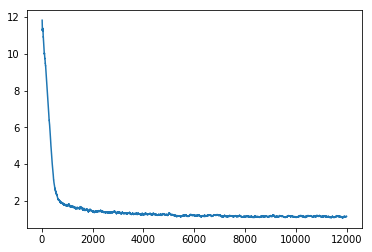

In [28]:
learner.sched.plot_loss()

In [21]:
#learner.load('resnext50_rgb_aug_2e-4_freezed')

Next, I unfreeze all weights and allow training of entire model. One trick that I use is differential learning rate: the lr of the head part is still lr, while the middle layers of the model are trained with lr/3, and the base is trained with even smaller lr/10. Despite the low-level detectors do not vary much from one image data set to another much, the yellow channel should be trained, and also the images are quite different from ImageNet; therefore, the I decrease the learning rate for first layers only by 10 times. If there was no necessity to train an additional channel and the images were more similar to ImageNet, the learning rates could be [lr/100,lr/10,lr]. Another trick is learning rate annealing. Periodic lr increase followed by slow decrease drives the system out of steep minima (when lr is high) towards broader ones (which are explored when lr decreases) that enhances the ability of the model to generalize and reduces overfitting. The length of the cycles gradually increases during training.

In [29]:
learner.unfreeze()
lrs=np.array([lr/9,lr/3,lr])

In [30]:
learner.fit(lrs, 2, cycle_len=1, cycle_mult=2, use_clr=(20,10))

epoch      trn_loss   val_loss   acc                                
    0      0.775675   0.705284   0.969443  
    1      0.744712   0.684031   0.970247                           
    2      0.729752   0.657528   0.971227                           



[0.6575279373007232, 0.9712271977788476]

In [31]:
learner.save('resnext50_rgb_aug005_2e-4_a1')

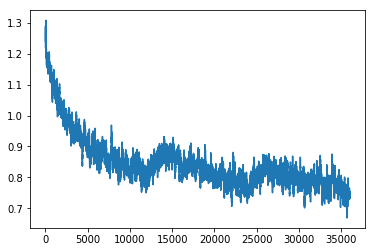

In [32]:
learner.sched.plot_loss()

In [33]:
learner.fit(lrs/4,1,cycle_len=4,use_clr=(20,10))

epoch      trn_loss   val_loss   acc                                
    0      0.748906   0.651313   0.971494  
    1      0.745487   0.648085   0.971737                           
    2      0.699843   0.644407   0.971785                           
    3      0.669659   0.627767   0.97238                            



[0.6277672062422812, 0.9723795983576576]

In [34]:
learner.save('resnext50_rgb_aug005_a2')

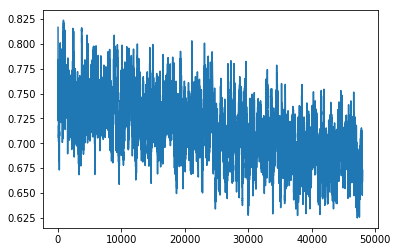

In [35]:
learner.sched.plot_loss()

In [259]:
learner.load('resnext50_rgb_aug005_a2')

In [260]:
learner.fit(lrs/16,1,cycle_len=2,use_clr=(10,20))

epoch      trn_loss   val_loss   acc                              
    0      0.67424    0.581247   0.973877  
    1      0.709337   0.575105   0.974086                        



[0.5751048761006109, 0.9740862327935929]

In [37]:
# learner.save('resnext50_rgb_aug005_a3')

In [261]:
learner.save('resnext50_rgb_aug005_a3')

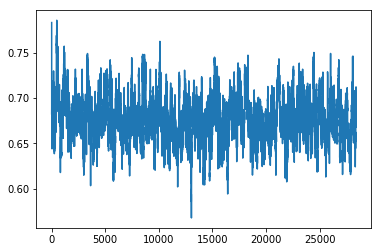

In [262]:
learner.sched.plot_loss()

In [263]:
learner.fit(lrs/64,1,cycle_len=1,use_clr=(10,20))

epoch      trn_loss   val_loss   acc                             
    0      0.661598   0.57504    0.973961  



[0.5750398412516043, 0.9739611919047163]

In [40]:
# learner.save('resnext50_rgb_aug005_a4')

In [264]:
learner.save('resnext50_rgb_aug005_a4')

In [41]:
#learner.fit(lrs/256,1,cycle_len=1,use_clr=(10,20))

epoch      trn_loss   val_loss   acc                                
    0      0.666756   0.62815    0.972555  



[0.6281498334202056, 0.9725553311695212]

In [42]:
#learner.save('ResNext50_aug005_a5')

In [46]:
#learner.load('resnext50_rgb_aug005_a4')

### Validation score

Evaluate the score with using TTA (test time augmentation).

In [265]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

In [266]:
n_aug = 16
preds,y = learner.TTA(n_aug=n_aug)
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)
pred_m = preds.mean(axis=-1)

In [267]:
preds.sort(axis=1)
pred_sm = preds[:,:,4:].mean(axis=-1)

Instead of 0.5, one can adjust the values of the threshold for each class individually to boost the score. The code below does it automatically.

In [8]:
def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [11]:
# max probability among TTA

th = fit_val(pred,y)
th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))
print('F1 each class max: ',f1_score(y, pred>th, average=None))

# average probability among TTA
th_m = fit_val(pred_m,y)
th_m[th_m<0.1] = 0.1
print('Thresholds average: ',th_m)
print('F1 macro: ',f1_score(y, pred_m > th_m, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred_m > 0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred_m > th_m, average='micro'))
print('F1 each class average: ',f1_score(y, pred_m > th_m, average=None))

# average probability among TTA
th_sm = fit_val(pred_sm,y)
th_sm[th_sm<0.1] = 0.1
print('Thresholds average: ',th_sm)
print('F1 macro: ',f1_score(y, pred_sm > th_sm, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred_sm > 0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred_sm > th_sm, average='micro'))
print('F1 each class average: ',f1_score(y, pred_sm > th_sm, average=None))

# # save results
# np.savetxt('../results/th_val_resnext50_rgb_aug005_a4_tta16',th)
# np.savetxt('../results/th_mval_resnext50_rgb_aug005_a4_tta16',th_m)
# np.savetxt('../results/th_smdval_resnext50_rgb_aug005_a4_tta16',th_sm)
# np.savetxt('../results/pred_resnext50_rgb_aug005_a4_tta16',pred)
# np.savetxt('../results/mpred_resnext50_rgb_aug005_a4_tta16',pred_m)
# np.savetxt('../results/smpred_resnext50_rgb_aug005_a4_tta16',pred_sm)
# np.savetxt('../results/y_resnext50_rgb_aug005_a4_all_tta16',y)


In [12]:
# # load results
# th = np.loadtxt('../results/th_val_resnext50_rgb_aug005_a4_tta16')
# th_m = np.loadtxt('../results/th_mval_resnext50_rgb_aug005_a4_tta16')
# #th_sm = np.loadtxt('../results/th_smdval_resnext50_rgb_aug005_a4_tta16')
# pred = np.loadtxt('../results/pred_resnext50_rgb_aug005_a4_tta16')
# pred_m = np.loadtxt('../results/mpred_resnext50_rgb_aug005_a4_tta16')
# y = np.loadtxt('../results/y_resnext50_rgb_aug005_a4_tta16')

In [15]:
# collect statistics
th_const = 0.375
th_fix = th_const * np.ones((28))
th_val = th_fix.copy()
th_val[15]=0.575 # manual 3

#np.savetxt('../results/th_val_manual_3_resnext50_rgb_aug005_a4_tta16',th_val)

f1_score_each = f1_score(y, pred > th, average=None)
f1_score_each_fix = f1_score(y, pred > th_fix, average=None)
f1_score_each_m = f1_score(y, pred_m > th_m, average=None)
f1_score_each_m_fix = f1_score(y, pred_m > th_fix, average=None)
f1_score_each_m_val = f1_score(y, pred_m > th_val, average=None)
#th_test = np.loadtxt('../results/th_log05_05')
#f1_score_each_m_05 = f1_score(y, pred_m > th_test , average=None)
print('Th fix:', th_fix)
print('F1 macro max: ',f1_score_each.mean())
print('F1 macro max th_fix: ',f1_score_each_fix.mean())
print('F1 macro avg: ',f1_score_each_m.mean())
print('F1 macro avg th_fix: ',f1_score_each_m_fix.mean())
print('F1 macro avg th_val: ',f1_score_each_m_val.mean())

labels = pd.read_csv(LABELS).set_index('Id')
labels_ext = pd.read_csv(LABELS_EXT).set_index('Id')
labels = pd.concat([labels, labels_ext])

label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:    
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)

df1 = pd.Series(f1_score_each)
df2 = pd.Series(th)
df3 = pd.Series(f1_score_each_m)
df4 = pd.Series(th_m)
df5 = pd.Series(f1_score_each_fix)
df6 = pd.Series(f1_score_each_m_fix)
df7 = pd.Series(th_fix)
df8 = pd.Series(f1_score_each_m_val)
df9 = pd.Series(th_val)
df10 = pd.Series(label_fraction)
df11 = pd.Series(label_count)
df12 = pd.Series((pred_m > th_m).mean(axis=0))
df13 = pd.Series((y > th_m).mean(axis=0))
df14 = pd.Series((pred_m > th_val).mean(axis=0))
df15 = pd.Series((y > th_val).mean(axis=0))
df16 = pd.Series(np.arange(28))
df_label = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16], axis=1)
df_label.columns = ['f1_max', 'th_max', 'f1_avg', 'th_avg', 'f1_max_fix','f1_avg_fix','th_fix', 'f1_avg_val',\
                    'th_val','label_frac','lable_cnt','Frac_thm(Pred)','Frac_thm(True)',\
                    'Frac_thv(Pred)','Frac_thv(True)','Class']
df_label

Th fix: [0.375 0.375 0.375 0.375 0.375 0.375 0.375 0.375 0.375 0.375 0.375 0.375 0.375 0.375 0.375 0.375 0.375 0.375
 0.375 0.375 0.375 0.375 0.375 0.375 0.375 0.375 0.375 0.375]
F1 macro max:  0.6471731203959296
F1 macro max th_fix:  0.5328623746374647
F1 macro avg:  0.662616325160165
F1 macro avg th_fix:  0.6267883811018115
F1 macro avg th_val:  0.6328760434394738


,f1_max,th_max,f1_avg,th_avg,f1_max_fix,f1_avg_fix,th_fix,f1_avg_val,th_val,label_frac,lable_cnt,Frac_thm(Pred),Frac_thm(True),Frac_thv(Pred),Frac_thv(True),Class
0,0.830909,0.510623,0.833532,0.450359,0.780375,0.813130,0.375,0.813130,0.375,0.387574,40958.0,0.407551,0.388248,0.485238,0.388248,0
1,0.813675,0.519469,0.807496,0.394945,0.760355,0.809365,0.375,0.809365,0.375,0.029069,3072.0,0.025643,0.029902,0.026684,0.029902,1
2,0.775225,0.491769,0.782609,0.410036,0.734935,0.778150,0.375,0.778150,0.375,0.102869,10871.0,0.088664,0.100681,0.096802,0.100681,2
3,0.737984,0.492937,0.738318,0.395182,0.673575,0.740061,0.375,0.740061,0.375,0.031501,3329.0,0.029523,0.031226,0.030659,0.031226,3
4,0.746015,0.520109,0.743478,0.447555,0.676445,0.734203,0.375,0.734203,0.375,0.048544,5130.0,0.040594,0.046461,0.047880,0.046461,4
5,0.622010,0.516512,0.624400,0.438708,0.551160,0.602740,0.375,0.602740,0.375,0.056190,5938.0,0.042960,0.055545,0.054977,0.055545,5
6,0.577320,0.515382,0.577381,0.435773,0.521212,0.567244,0.375,0.567244,0.375,0.035249,3725.0,0.026306,0.037282,0.033781,0.037282,6
7,0.758356,0.504788,0.760750,0.417580,0.667228,0.757623,0.375,0.757623,0.375,0.088997,9405.0,0.079201,0.092449,0.090651,0.092449,7
8,0.736842,0.904402,0.756757,0.735569,0.387097,0.625000,0.375,0.625000,0.375,0.002053,217.0,0.001703,0.001798,0.002744,0.001798,8
9,0.555556,0.588666,0.648649,0.376778,0.358209,0.648649,0.375,0.648649,0.375,0.001864,197.0,0.001987,0.001514,0.001987,0.001514,9


In [275]:
#th_lab1 = (label_fraction*0.5 + 0.7/2)
th_lab = np.ones((28))*0.375
# th_lab[15]=0.575
#th_lab[26]=0.375

f1_score_each_m_fix = f1_score(y, pred_m > th_lab, average=None)
f1_score_each_m_fix, f1_score_each_m_fix.mean()

(array([0.81809, 0.82871, 0.7514 , 0.74119, 0.7419 , 0.64685, 0.61919, 0.7581 , 0.7    , 0.77273, 0.68293,
        0.70698, 0.72   , 0.66914, 0.83333, 0.77778, 0.53125, 0.53191, 0.4924 , 0.64496, 0.4    , 0.68351,
        0.5595 , 0.82117, 0.62963, 0.69542, 0.47826, 0.66667]),
 0.6751078057594209)

In [276]:
th_m

array([0.44122, 0.35931, 0.43636, 0.36284, 0.3912 , 0.40218, 0.39123, 0.41221, 0.46642, 0.49059, 0.52994,
       0.35887, 0.37435, 0.40088, 0.39071, 0.38946, 0.42036, 0.57844, 0.37469, 0.37537, 0.47828, 0.416  ,
       0.37453, 0.41855, 0.63919, 0.47836, 0.40893, 0.49624])

### Submission

In [277]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

In [278]:
n_aug = 16
preds_t,y_t = learner.TTA(n_aug=n_aug,is_test=True)

In [279]:
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1) #max works better for F1 macro score
pred_t_m = preds_t.mean(axis=-1) #max works better for F1 macro score

In [280]:
preds_t.sort(axis=1)
pred_t_sm = preds_t[:,:,4:].mean(axis=-1)

**It is very important to keep the same order of ids as in the sample submission** https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/69366#409041 since the competition metric relies only on the order of recods ignoring IDs.

In [281]:
def save_pred(pred, th=0.5, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    #set_trace()
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

Similar to validation, additional adjustment may be done based on the public LB probing results (https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/68678) to predict approximately the same fraction of images of a particular class as expected from the public LB.

Somehow the thresholds that I found manually for one of the models are working the best.

In [ ]:
# th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
#                0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
#                0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
# print('Fractions: ',(pred_t > th_t).mean(axis=0))
# save_pred(pred_t,th_t)

Automatic fitting the thresholds based on the public LB statistics.

In [ ]:
# lb_prob = [
#  0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
#  0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
#  0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
#  0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
#  0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
#  0.222493880,0.028806584,0.010000000]
# # I replaced 0 by 0.01 since there may be a rounding error leading to 0

In [282]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

Save also predictions for a threshold calculated based on the validation set and constant value 0.5:

In [72]:
save_pred(pred_t,0.5,'../submit/HPAC_05_resnext50_rgb_aug005_a4_tta16.csv') 

In [284]:
#save_pred(pred_t_m,0.4,'../submit/HPAC_04_m_resnext50_rgb_aug005_a4_tta16.csv') # PLB: 0.574
#save_pred(pred_t_m,0.45,'../submit/HPAC_045_m_resnext50_rgb_aug005_a4_tta16.csv') # PLB: 0.556
#save_pred(pred_t_m,0.375,'../submit/HPAC_0375_m_resnext50_rgb_aug005_a4_tta16.csv') # PLB: 0.582
#save_pred(pred_t_m,0.35,'../submit/HPAC_035_m_resnext50_rgb_aug005_a4_tta16.csv') # PLB: 0.579

In [285]:
th_val = np.loadtxt('../results/th_val_manual_3_resnext50_rgb_aug005_a4_tta16')
save_pred(pred_t_m,th_val,'../submit/HPAC_th_manual_3_resnext50_rgb_aug005_a4_tta16.csv') # PLB: 0.585

Try using the threshold from validation set for classes not present in the public LB:

In [ ]:
# class_list = [8,9,10,15,20,24,27]
# for i in class_list:
#     th_t[i] = th[i]
# save_pred(pred_t,th_t,'protein_classification_c.csv')

Try fitting thresholds based on the frequency of classes in the train dataset:

In [ ]:
# # use legacy data for label_fraction
# labels = pd.read_csv(LABELS).set_index('Id')
# label_count = np.zeros(len(name_label_dict))
# for label in labels['Target']:
#     l = [int(i) for i in label.split()]
#     label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
# label_fraction = label_count.astype(np.float)/len(labels)
# label_count, label_fraction

(array([12885.,  1254.,  3621.,  1561.,  1858.,  2513.,  1008.,  2822.,    53.,    45.,    28.,  1093.,
          688.,   537.,  1066.,    21.,   530.,   210.,   902.,  1482.,   172.,  3777.,   802.,  2965.,
          322.,  8228.,   328.,    11.]),
 array([0.41468, 0.04036, 0.11654, 0.05024, 0.0598 , 0.08088, 0.03244, 0.09082, 0.00171, 0.00145, 0.0009 ,
        0.03518, 0.02214, 0.01728, 0.03431, 0.00068, 0.01706, 0.00676, 0.02903, 0.0477 , 0.00554, 0.12156,
        0.02581, 0.09542, 0.01036, 0.2648 , 0.01056, 0.00035]))

In [74]:
th_t = np.loadtxt('../results/th_val_resnext50_rgb_aug005_a4_tta16')
save_pred(pred_t,th_t,'../submit/HPAC_val_resnext50_rgb_aug005_a4_tta16.csv')

In [80]:
th_t_m = np.loadtxt('../results/th_mval_resnext50_rgb_aug005_a4_tta16')
save_pred(pred_t_m,th_t_m,'../submit/HPAC_mval_ResNext50_aug005_a4_tta16.csv') 

In [58]:
# use original data for label_fraction - no external or augmented data
labels = pd.read_csv(LABELS).set_index('Id')

label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:    
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)

In [74]:
# th_t = fit_test(pred_t,label_fraction)
# th_t[th_t<0.05] = 0.05
# print('Thresholds: ',th_t)
# print('Fractions: ',(pred_t > th_t).mean(axis=0))
# np.savetxt('../results/HPAC_olab_resnext50_rgb_aug_2e-4_a4_tta16',th_t)
# save_pred(pred_t,th_t,'../submit/HPAC_olab_resnext50_rgb_aug_2e-4_a4_tta16.csv') 

Thresholds:  [0.55696 0.43368 0.44955 0.40915 0.37304 0.39629 0.443   0.44438 0.35654 0.39693 0.45626 0.55344 0.46253
 0.34222 0.58177 0.34889 0.58546 0.97153 0.54015 0.46577 0.53824 0.48426 0.50026 0.44426 0.54724 0.54331
 0.52241 0.9763 ]
Fractions:  [0.41472 0.03965 0.11314 0.04931 0.05734 0.07802 0.03187 0.08879 0.00162 0.00145 0.00085 0.03495 0.02162
 0.01701 0.0341  0.00068 0.01683 0.00667 0.02914 0.047   0.0053  0.11921 0.02521 0.09374 0.01017 0.2644
 0.01017 0.00043]


In [81]:
# th_t = fit_test(pred_t,label_fraction)
# th_t[th_t<0.05] = 0.05
# print('Thresholds: ',th_t)
# print('Fractions: ',(pred_t > th_t).mean(axis=0))
# np.savetxt('../results/HPAC_lab_resnext50_rgb_aug_2e-4_a4_tta16',th_t)
# save_pred(pred_t,th_t,'../submit/HPAC_lab_resnext50_rgb_aug_2e-4_a4_tta16.csv') 

In [82]:
# # use all data for label_fraction - include augmented data
# labels = pd.read_csv(LABELS).set_index('Id')
# labels_ext = pd.read_csv(LABELS_EXT).set_index('Id')
# labels_aug = pd.read_csv(LABELS_AUG).set_index('Id')
# labels = pd.concat([labels, labels_ext, labels_aug])

# label_count = np.zeros(len(name_label_dict))
# for label in labels['Target']:    
#     l = [int(i) for i in label.split()]
#     label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
# label_fraction = label_count.astype(np.float)/len(labels)
# df1 = pd.Series(f1_score_each)
# df2 = pd.Series(label_count)
# df3 = pd.Series(label_fraction)
# df_label = pd.concat([df1, df2, df3], axis=1)
# df_label.columns = ['f1_score', 'lable_count','label_fraction']
# df_label

In [83]:
# th_t = fit_test(pred_t,label_fraction)
# th_t[th_t<0.05] = 0.05
# print('Thresholds: ',th_t)
# print('Fractions: ',(pred_t > th_t).mean(axis=0))
# np.savetxt('../results/HPAC_alab_resnext50_rgb_aug_2e-4_a4_tta16',th_t)
# save_pred(pred_t,th_t,'../submit/HPAC_alab_resnext50_rgb_aug_2e-4_a4_tta16.csv')

In [286]:
def save_pred_t(pred_t, fname='pred_t_model_input_lr.csv'):
    pred_list = []
    for line in pred_t:
        pred_list.append(line)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame(pred_list_cor)
    df.to_csv(fname, header=False, index=False) # for ensemble averaging

In [287]:
save_pred_t(pred_t, '../results/pred_t_resnext50_rgb_aug005_a4_tta16.csv')

In [288]:
df_pred_t = pd.read_csv('../results/pred_t_resnext50_rgb_aug005_a4_tta16.csv',header=None)
df_pred_t.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.339938,0.093312,0.764889,0.201171,0.057805,0.105268,0.109823,0.199740,0.015154,0.023426,...,0.099195,0.142249,0.053584,0.200186,0.158782,0.132128,0.067641,0.278235,0.038752,0.030379
1,0.364351,0.117877,0.167920,0.169728,0.181995,0.724664,0.289464,0.146372,0.046970,0.028686,...,0.122846,0.139037,0.096981,0.279638,0.172117,0.183100,0.198010,0.495467,0.193927,0.071379
2,0.587343,0.096149,0.182552,0.078838,0.216836,0.626080,0.147108,0.172201,0.010848,0.014175,...,0.109956,0.168195,0.018212,0.444863,0.106637,0.118323,0.066185,0.665645,0.079277,0.047344
3,0.729179,0.143390,0.282479,0.160160,0.188973,0.266537,0.156248,0.312707,0.085387,0.074513,...,0.273623,0.188790,0.089684,0.402834,0.193705,0.220831,0.090607,0.507101,0.135221,0.095200
4,0.499249,0.352025,0.272627,0.148767,0.098452,0.245091,0.230374,0.330666,0.337282,0.104042,...,0.133336,0.143223,0.365295,0.330490,0.188156,0.467077,0.133672,0.523338,0.150112,0.071342


In [289]:
save_pred_t(pred_t_m, '../results/pred_t_m_resnext50_rgb_aug005_a4_tta16.csv')

In [290]:
save_pred_t(pred_t_sm, '../results/pred_t_sm_resnext50_rgb_aug005_a4_tta16.csv')